In [2]:
import os
import time
import numpy as np
from tqdm import tqdm
import jax
import jax.numpy as jnp
from jax import random
import optax
from flax import linen as nn
from flax.training import train_state

import pickle
from scipy.integrate import solve_ivp

class MLP(nn.Module):
    dim: int
    out_dim: int = 1
    w: int = 128

    @nn.compact
    def __call__(self, x):
        x = nn.Dense(self.w)(x)
        x = nn.selu(x)
        x = nn.Dense(self.w)(x)
        x = nn.selu(x)
        x = nn.Dense(self.w)(x)
        x = nn.selu(x)
        x = nn.Dense(self.out_dim)(x)
        return x
    
model = MLP(dim=22, out_dim=16)

@jax.jit
def predict(params, inputs):
    return model.apply({"params": params}, inputs)

savedir = "models/epoch200k"
with open(f'{savedir}/w.pkl', 'rb') as f:
    params = pickle.load(f)

In [3]:
points = [(10, 10), (40, 40), (50, 10)]

In [11]:
from solver import pde_solution
from kl_extension import KLExpansion
from utils import get_d_from_u

def ode_function(t, m, d, e):
    m = m.reshape(1, -1)
    t = jnp.array(t).reshape(1,-1)
    inputs = jnp.concatenate([m, d, e, t], axis=1)
    return predict(params, inputs)[0]

kl = KLExpansion(grid=(64, 64))
kl.calculate_eigh()

subkey = jax.random.PRNGKey(0)

In [15]:
m = np.random.normal(size = 16)
print(m)
log_kappa = kl.expansion(m)

errors = []
sols = []

for i in tqdm(range(100)):
    subkey, batch_key = jax.random.split(subkey)
    m0 = jax.random.normal(batch_key, (1, 16)) 
    e = np.array([0.2, 0.9])
    u = pde_solution(log_kappa, (e[0], e[1]), verbose=False)
    d = get_d_from_u(u, points)
    m = jnp.array(m).reshape(1,-1)
    e = jnp.array(e).reshape(1,-1)
    d = jnp.array(d).reshape(1,-1)
    solution = solve_ivp(ode_function, t_span=[0, 1], y0=m0[0], t_eval=None, args=(d, e))
    log_kappa = kl.expansion(solution.y[:, -1])
    u = pde_solution(log_kappa, e[0], verbose=False)
    d_pred = get_d_from_u(u, points)
    sols.append(solution.y[:, -1])
    try:
        error = np.linalg.norm(d - d_pred) / np.linalg.norm(d)
        errors.append(error)
    except ValueError:
        pass


print(np.mean(errors), np.std(errors))

[ 0.72384914 -0.08331582  0.26970079 -0.99566597 -0.00834393 -0.63549146
  1.12623324 -1.08340413 -0.41189363 -0.22678959 -0.80889115 -0.34217604
 -0.67027289 -1.81426398 -0.24071637 -0.6043767 ]


100%|█████████████████████████████████████████| 100/100 [01:25<00:00,  1.16it/s]

0.008070968 0.005342768


In [18]:
m

Array([[ 0.7238491 , -0.08331582,  0.2697008 , -0.99566597, -0.00834393,
        -0.6354915 ,  1.1262332 , -1.0834042 , -0.41189364, -0.2267896 ,
        -0.8088912 , -0.34217605, -0.6702729 , -1.8142639 , -0.24071637,
        -0.6043767 ]], dtype=float32)

In [17]:
np.mean(sols, axis=0)

array([ 0.60679345, -0.11262297,  0.5927336 , -0.0513853 ,  0.6663318 ,
       -0.63922498,  0.51105927, -0.49615948,  0.08054715,  0.13030349,
       -0.36711461,  0.15741506,  0.12787229,  0.03601954,  0.10582677,
        0.08126816])

In [4]:
import numpy as np

points = [(10, 10), (40, 40), (50, 10)]

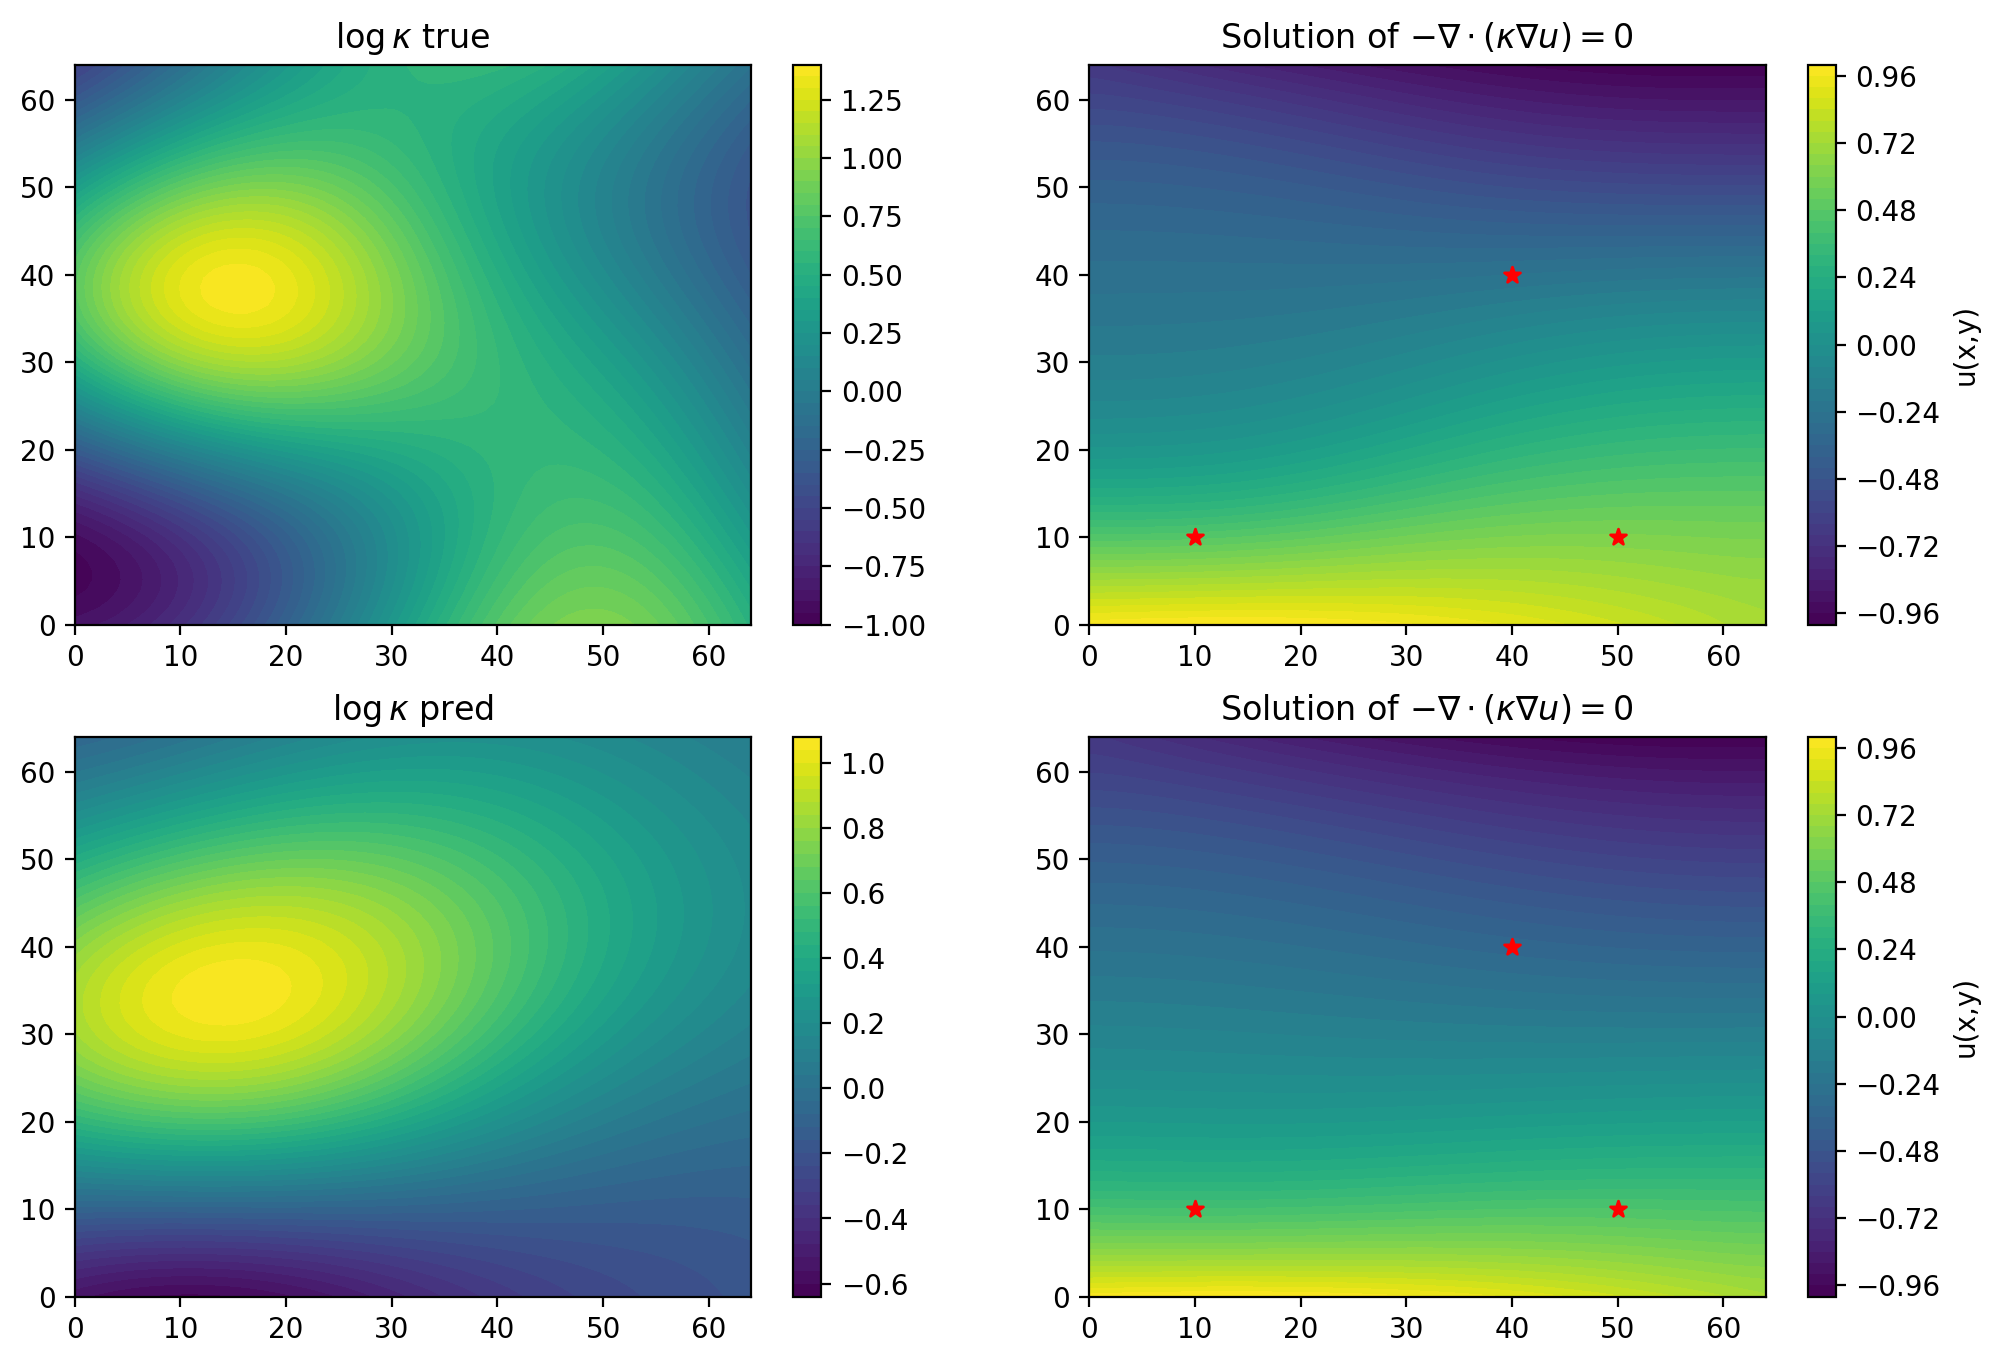

In [6]:
from solver import pde_solution
from kl_extension import KLExpansion
from utils import get_d_from_u
import matplotlib.pyplot as plt

kl = KLExpansion(grid=(64, 64))
kl.calculate_eigh()

m = np.array([ 0.7238491 , -0.08331582,  0.2697008 , -0.99566597, -0.00834393,
        -0.6354915 ,  1.1262332 , -1.0834042 , -0.41189364, -0.2267896 ,
        -0.8088912 , -0.34217605, -0.6702729 , -1.8142639 , -0.24071637,
        -0.6043767 ])
m_avg = np.array([ 0.60679345, -0.11262297,  0.5927336 , -0.0513853 ,  0.6663318 ,
       -0.63922498,  0.51105927, -0.49615948,  0.08054715,  0.13030349,
       -0.36711461,  0.15741506,  0.12787229,  0.03601954,  0.10582677,
        0.08126816])
e = np.array([0.2, 0.9])

point_inv = [(x[1],x[0]) for x in points]
log_kappa = kl.expansion(m)
u = pde_solution(log_kappa, e, verbose=False)
d = get_d_from_u(u, points)
log_kappa_pred = kl.expansion(m_avg)
u_pred = pde_solution(log_kappa_pred, e, verbose=False)
d_pred = get_d_from_u(u_pred, points)

plt.figure(figsize=(12, 8), dpi=200)
plt.subplot(221)
plt.contourf(kl.X_mesh*64, kl.Y_mesh*64, log_kappa, levels=50, cmap='viridis')
plt.colorbar()
plt.title(fr'$\log \kappa$ true')
plt.subplot(222)
plt.contourf(kl.X_mesh*64, kl.Y_mesh*64, u, levels=50, cmap='viridis')
plt.colorbar(label='u(x,y)')
plt.scatter([x[0] for x in points],[x[1] for x in points], color='r', marker='*')
plt.title(fr'Solution of $-\nabla \cdot (\kappa \nabla u) = 0$')
plt.subplot(223)
plt.contourf(kl.X_mesh*64, kl.Y_mesh*64, log_kappa_pred, levels=50, cmap='viridis')
plt.colorbar()
plt.title(fr'$\log \kappa$ pred')
plt.subplot(224)
plt.contourf(kl.X_mesh*64, kl.Y_mesh*64, u_pred, levels=50, cmap='viridis')
plt.colorbar(label='u(x,y)')
plt.scatter([x[0] for x in points],[x[1] for x in points], color='r', marker='*')
plt.title(fr'Solution of $-\nabla \cdot (\kappa \nabla u) = 0$')
plt.savefig('imgs/avg_pred.png')
plt.show()

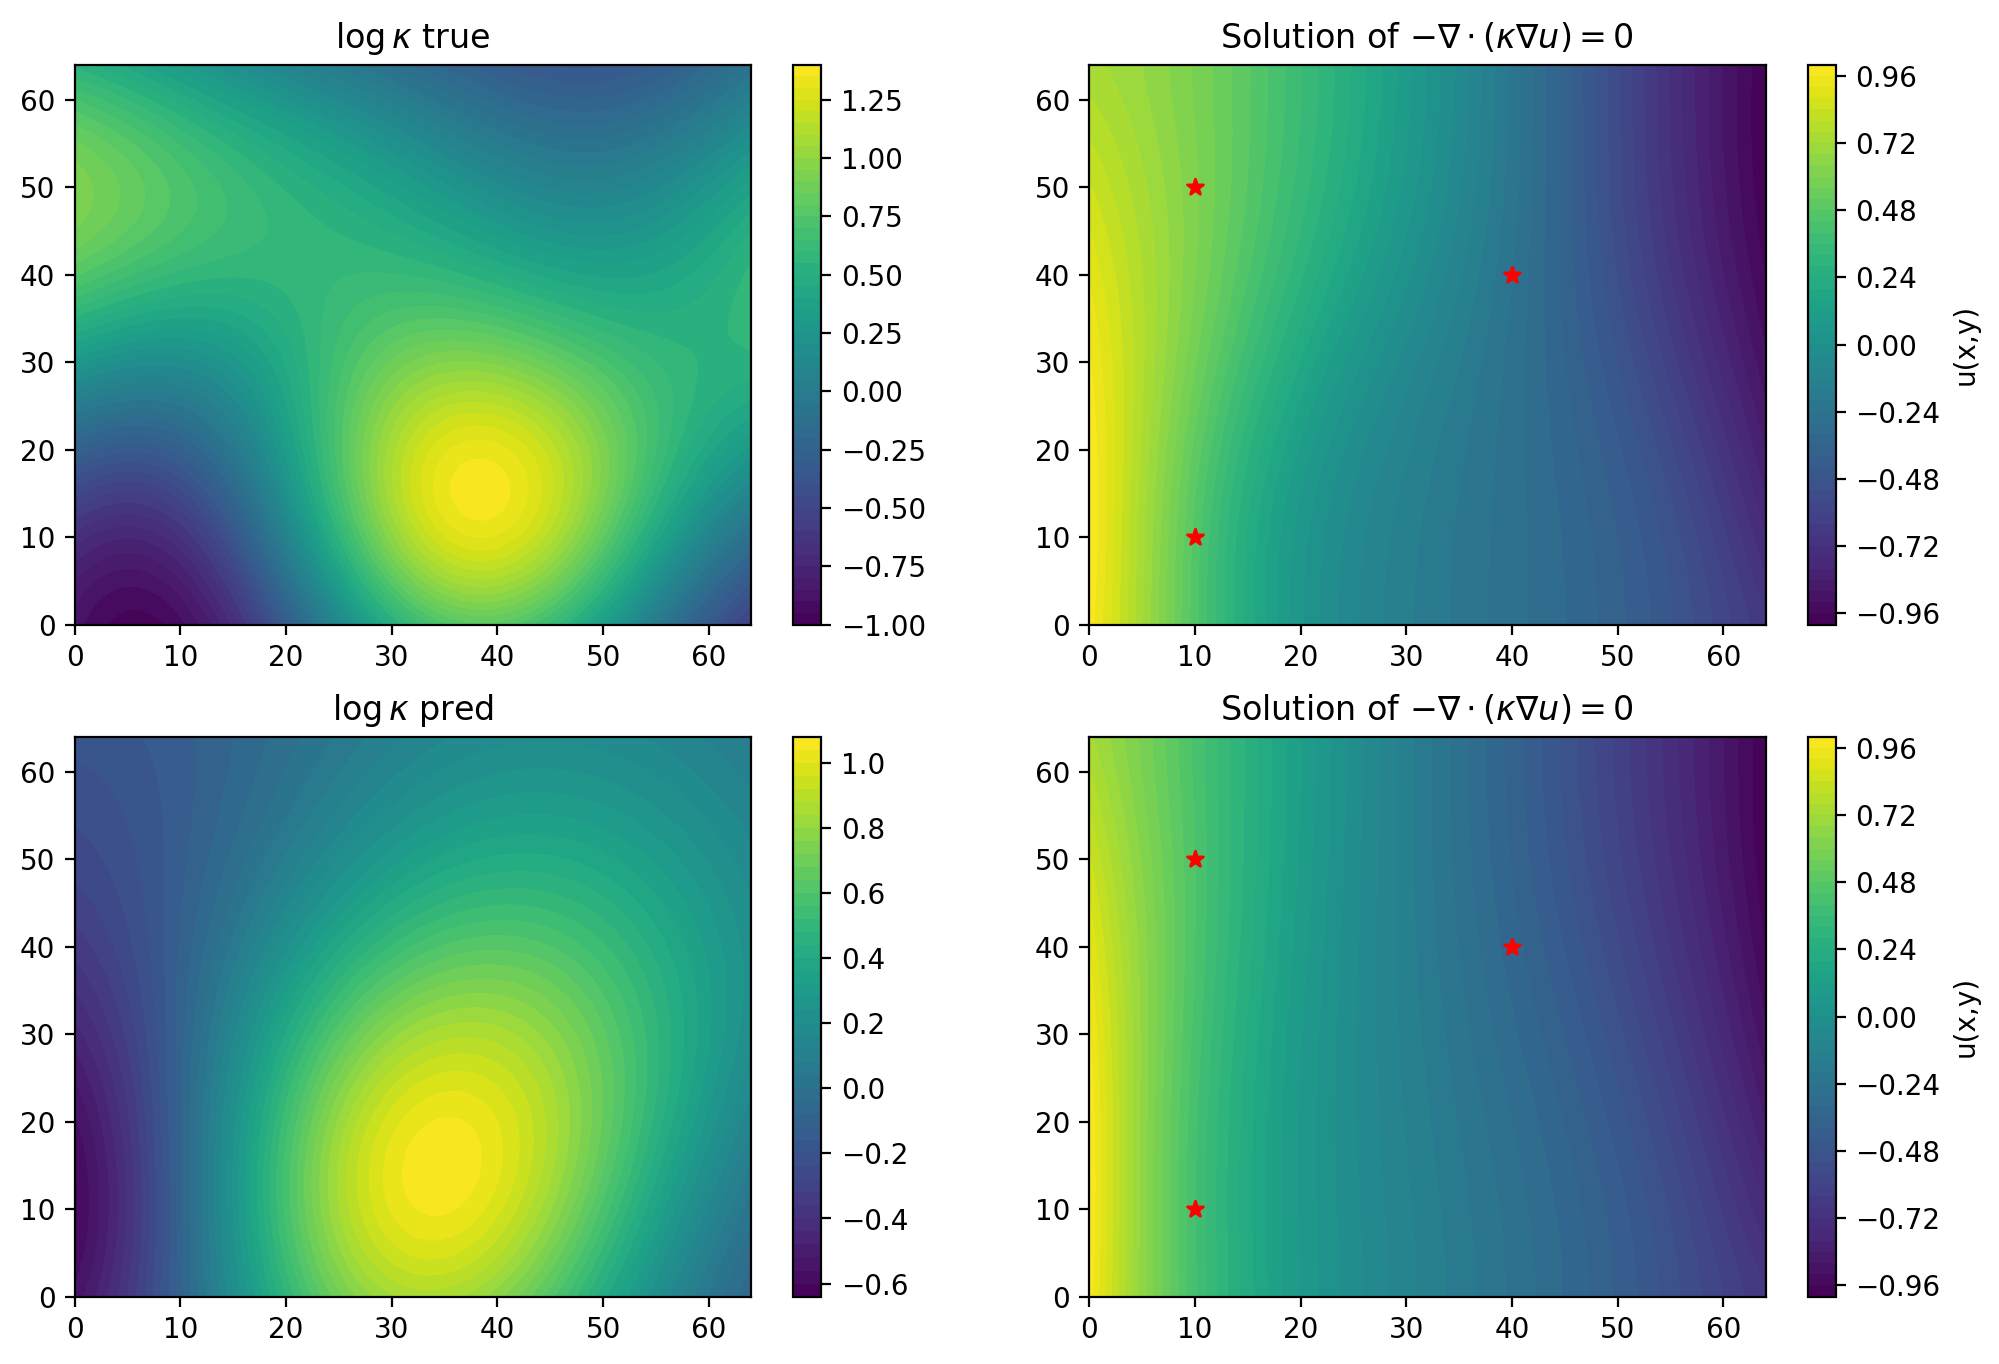

In [9]:
plt.figure(figsize=(12, 8), dpi=200)
plt.subplot(221)
plt.contourf(kl.X_mesh*64, kl.Y_mesh*64, log_kappa.T, levels=50, cmap='viridis')
plt.colorbar()
plt.title(fr'$\log \kappa$ true')
plt.subplot(222)
plt.contourf(kl.X_mesh*64, kl.Y_mesh*64, u.T, levels=50, cmap='viridis')
plt.colorbar(label='u(x,y)')
plt.scatter([x[1] for x in points],[x[0] for x in points], color='r', marker='*')
plt.title(fr'Solution of $-\nabla \cdot (\kappa \nabla u) = 0$')
plt.subplot(223)
plt.contourf(kl.X_mesh*64, kl.Y_mesh*64, log_kappa_pred.T, levels=50, cmap='viridis')
plt.colorbar()
plt.title(fr'$\log \kappa$ pred')
plt.subplot(224)
plt.contourf(kl.X_mesh*64, kl.Y_mesh*64, u_pred.T, levels=50, cmap='viridis')
plt.colorbar(label='u(x,y)')
plt.scatter([x[1] for x in points],[x[0] for x in points], color='r', marker='*')
plt.title(fr'Solution of $-\nabla \cdot (\kappa \nabla u) = 0$')
plt.savefig('imgs/avg_pred_t.png')
plt.show()

In [38]:
d

array([ 0.45756175, -0.25602236, -0.41482352])

In [39]:
d_pred

array([ 0.39559728, -0.35525756, -0.43845707])

In [36]:
np.linalg.norm(d-d_pred)/np.linalg.norm(d)

0.2583137817462856